# Table of Contents

[1. Project Scope](https://github.com/winter2897/Real-time-Auto-License-Plate-Recognition-with-Jetson-Nano/blob/main/doc/dataset.md)

[2. Downloading the Dataset](https://colab.research.google.com/drive/17dG0QD5yYjLaOIoVS_FDLsjw5IJDzZ8Z#scrollTo=zKSoOvAyjLe2&line=1&uniqifier=1)

[3. Getting Started with OpenCV](https://colab.research.google.com/drive/17dG0QD5yYjLaOIoVS_FDLsjw5IJDzZ8Z#scrollTo=hGgQsFLDAwdp)

# 1. Project Scope

In this project, we will explore the usage of Computer Vision for performing segmentation process.

We are going to segment region of license plate from a given input image. 

# 2. Downloading the Dataset

The original dataset is available from this repo

https://github.com/winter2897/Real-time-Auto-License-Plate-Recognition-with-Jetson-Nano

for the convenience of this hands-on, 
we already pre-process the original data and make it available on Google drive
https://drive.google.com/uc?id=1dEKJryADIJBZq8NwVtxZBR2IbaENpFU9

You can download the dataset manually or using the script as given below:

In [1]:
!gdown https://drive.google.com/uc?id=1dEKJryADIJBZq8NwVtxZBR2IbaENpFU9

Downloading...
From: https://drive.google.com/uc?id=1dEKJryADIJBZq8NwVtxZBR2IbaENpFU9
To: /content/lpr.zip
100% 4.66M/4.66M [00:00<00:00, 136MB/s]


## extracting the zipped dataset

In [2]:
!unzip -q -o lpr.zip

# 3. Getting started with OpenCV - case study: image segmentation

## Importing the necessary libraries

`os` for file operations such as listding the content of a directory and handling paths, 

`cv2` is OpenCV libary for python
This library provides various methods that are useful creating computer vision based applications

`pyplot` is useful for displaying images in juypter environment

In [3]:
import os
import cv2
import matplotlib.pyplot as plt

## listing the image files
the dataset folder contains images and their corresponding annotation contains bounding box of the license plate. 

The bounding boxes are not tight enough to the license plate, leaving some rooms outside the license plate.

In [4]:
root = 'lpr'
files = os.listdir(root)
files = [x for x in files if '.txt' not in x]

In [5]:
print(files[:3])

['xemay1233.jpg', 'xemay1446.jpg', 'xemay1073.jpg']


## test to read the annotation file

In [6]:
for i, name in enumerate(files):
    img_file = os.path.join(root, name)
    anno_file = img_file.replace('.jpg', '.txt')
        
    with open(anno_file) as f:
        annotation = [float(x) for x in f.readline().strip().split(' ')]

    print(img_file)
    print(anno_file)
    print(annotation)
    break

lpr/xemay1233.jpg
lpr/xemay1233.txt
[0.0, 0.559322, 0.422442, 0.190678, 0.290429]


## convertion of bounding box format

In [7]:
def absoluteBBox(img_w,img_h, x,y,w,h):
    x = int(x*img_w)
    y = int(y*img_h)
    w = int(w*img_w)
    h = int(h*img_h)
    
    x1 = int(x-w/2)
    y1 = int(y-h/2)
    x2 = int(x1+w)
    y2 = int(y1+h)
    
    return x1,y1,x2,y2

## reading all of the annotation data

In [8]:
annotations = []
for i, name in enumerate(files):
    img_file = os.path.join(root, name)
    anno_file = img_file.replace('.jpg', '.txt')
        
    with open(anno_file) as f:
        annotation = [float(x) for x in f.readline().strip().split(' ')]
        annotations.append(annotation)
    

## simple segmentation

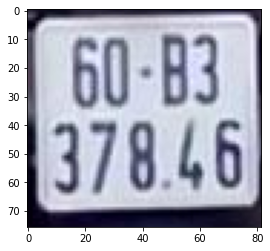

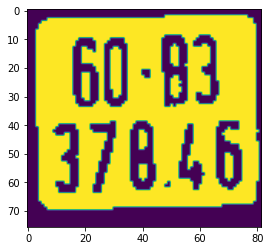

In [9]:
idx = 142

img = cv2.imread(os.path.join(root, files[idx]))
img_h,img_w,_ = img.shape

_, x, y, w, h = annotations[idx]

x1,y1,x2,y2 = absoluteBBox(img_w,img_h, x,y,w,h)
patch = img[y1:y2, x1:x2]

mask = cv2.inRange(patch, (150,150,150), (255,255,255))
plt.imshow(patch[:,:,::-1])
plt.figure()
plt.imshow(mask)

## Finding the proper thresholds

In [10]:
def color_segmentation(img, lower=(82, 0, 159), upper=(255, 255, 255), method="RGB"):
    
    if method == "RGB":
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    elif method == "HSV":
        img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    elif method == "YCrCb":
        img = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
    elif method == "LAB":
        img = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    else:
        raise method+" colorspace is not supported!"

    img = cv2.inRange(img, lower, upper)

    return img

(175, 0, 0)
(255, 255, 255)


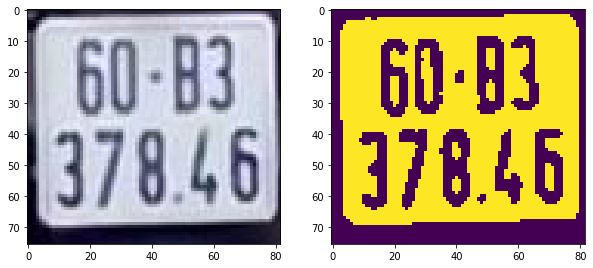

In [11]:
#@title  { run: "auto" }

mode = "YCrCb" #@param ["RGB", "HSV", "LAB", "YCrCb"]
color1_low = 175 #@param {type:"slider", min:0, max:255, step:1}
color1_high = 255 #@param {type:"slider", min:0, max:255, step:1}

color2_low = 0 #@param {type:"slider", min:0, max:255, step:1}
color2_high = 255 #@param {type:"slider", min:0, max:255, step:1}

color3_low = 0 #@param {type:"slider", min:0, max:255, step:1}
color3_high = 255 #@param {type:"slider", min:0, max:255, step:1}

thresh_low = color1_low, color2_low, color3_low
thresh_high = color1_high, color2_high, color3_high
print(thresh_low)
print(thresh_high)

mask = color_segmentation(patch, thresh_low, thresh_high, mode)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(patch[:,:,::-1])
plt.subplot(1,2,2)
plt.imshow(mask)

## Extracting the license plate region

In [12]:
def getLargestArea(image, mask):
    ret,thresh = cv2.threshold(mask, 40, 255, 0)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    output = cv2.bitwise_and(image, image, mask=mask)
    x=y=w=h=0

    if len(contours) != 0:
        # draw in blue the contours that were founded
        # cv2.drawContours(output, contours, -1, 255, 3)

        # find the biggest countour (c) by the area
        c = max(contours, key = cv2.contourArea)
        x,y,w,h = cv2.boundingRect(c)

        # draw the biggest contour (c) in green
        cv2.rectangle(output,(x,y),(x+w,y+h),(0,255,0),2)
    
    return output, (x,y,w,h)

(3, 2, 77, 68)


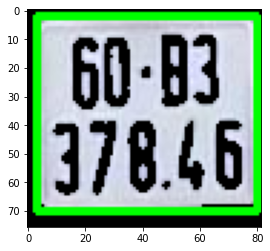

In [13]:
plate, bbox = getLargestArea(patch, mask)
plt.imshow(plate[:,:,::-1])
print(bbox)

## vertically splits the image into 2 parts

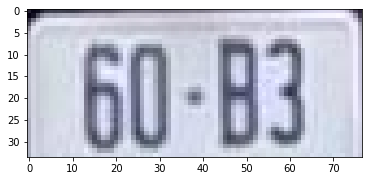

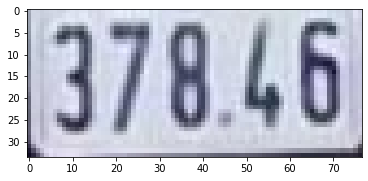

In [14]:
x,y,w,h = bbox
license_plate = patch[y:y+h, x:x+w]
plate_h, plate_w, _ = license_plate.shape

plt.imshow(license_plate[0:plate_h//2][:,:,::-1])
plt.figure()
plt.imshow(license_plate[plate_h//2:][:,:,::-1])